# Cell Segmentation with U-Net
## Methodology
This notebook demonstrates the process of segmenting cells in biomedical images using the U-Net architecture.

### Overview:
1. **Dataset Download**: Instructions on how to download the dataset from Kaggle.
2. **Data Preprocessing**: Using `data_loader.py` to load and preprocess the dataset.
3. **Model Building**: Defining and training the U-Net model.
4. **Evaluation**: Assessing the model's performance.
5. **Visualization**: Using `utils.py` to visualize the results.

This project aims to provide a comprehensive workflow for cell segmentation, facilitating further research and development in biomedical image analysis.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import sys
sys.path.append('/content/drive/My Drive/Cell-Segmentation-with-UNet/Scripts')

## Imports

In [8]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
# Import custom scripts
from data_loader import unzip_to_original_subfolders, get_data_paths, preprocess_image, preprocess_mask, load_dataset
from utils import display_random_sample

## Dataset Download Instructions


The dataset used in this project is from the 2018 Data Science Bowl, available on Kaggle. Follow these steps to download and prepare the dataset:

1. Go to [Kaggle Dataset Link](https://www.kaggle.com/c/data-science-bowl-2018/data).
2. Download the dataset to your local machine.
3. Unzip the dataset into the `data` directory of this project.

Alternatively, you can use the provided script in the `Scripts` directory to automate this process.


In [9]:
# Importing necessary libraries for file upload in Google Colab
from google.colab import files

# Prompting for file upload (e.g., kaggle.json for API authentication) in Google Colab
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahdihabibi","key":"9c649f099a1c0bcb7f3ca5b2fe7403a9"}'}

In [10]:
# Setup for Kaggle API and move the uploaded kaggle.json file into the Kaggle directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Change the permissions of the file

# Download the 2018 Data Science Bowl dataset
!kaggle competitions download -c data-science-bowl-2018

100% 357M/358M [00:03<00:00, 109MB/s] 
100% 358M/358M [00:03<00:00, 119MB/s]


In [11]:
# Unzip the dataset
!unzip -q data-science-bowl-2018.zip -d dsb2018

# Call the function on 'dsb2018' directory
unzip_to_original_subfolders('dsb2018')

## Load and Preprocess the Dataset

In [12]:
# Define image dimensions and path to training data
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 128, 128, 3
TRAIN_PATH = '/content/dsb2018/stage1_train/'

# Load the dataset
X_train, Y_train = load_dataset(TRAIN_PATH, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

## Display a Random Sample

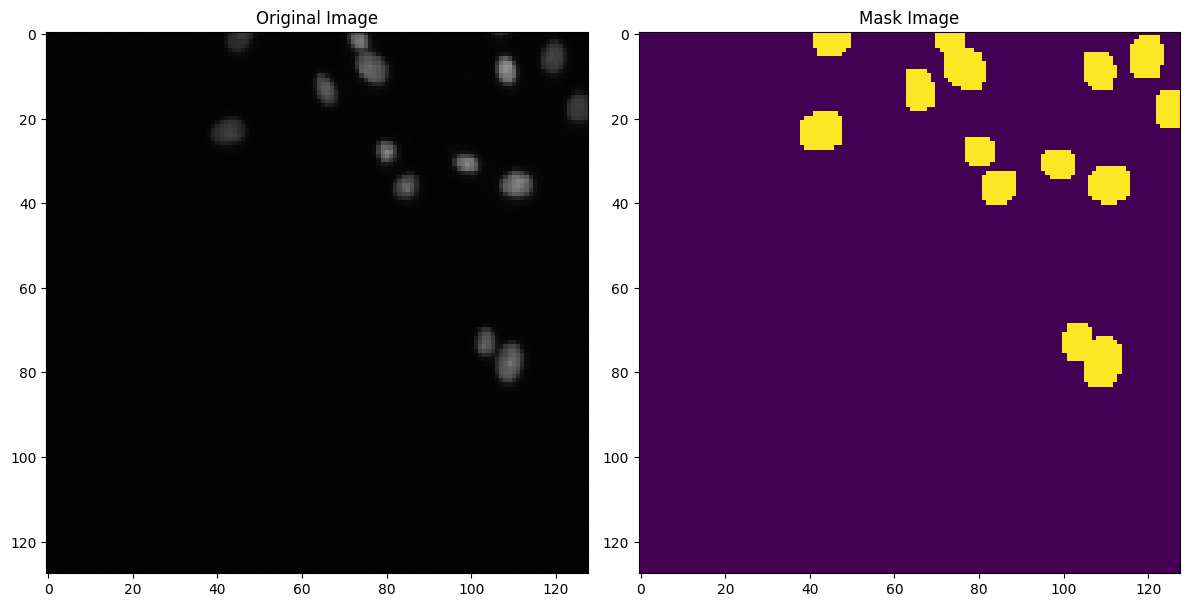

In [19]:
display_random_sample(X_train, Y_train)